In [1]:
!python3 -m venv env

In [2]:
!source env/bin/activate

In [3]:
!python3 -m pip install seaborn


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip install xgboost


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import pandas as pd
import numpy as np
import os

from scipy.stats import zscore #tells how far datapoint is from mean (error measurement)
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.decomposition import PCA #dimensionality reduction
from sklearn.impute import SimpleImputer #Replaces missing values with some kind of standard or qualitative data
from sklearn.preprocessing import OneHotEncoder #Converts categorical data into numerical 
from sklearn.preprocessing import StandardScaler #standardizes features by scaling to unit variance and removing mean

from sklearn.linear_model import LogisticRegression #imports model 
#Import other models we are using
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import PrecisionRecallDisplay
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import cross_validate #estimates skill of model on new data
from sklearn.metrics import roc_auc_score #compares true positives / false positives
from sklearn import metrics
from sklearn.inspection import permutation_importance

import joblib
import pickle

In [6]:
#reads in compiled, merged df
merged_nhanes_df = pd.read_csv('../data/processed/merged_nhanes.csv')

In [7]:
merged_nhanes_df['CFDCST1'] = zscore(merged_nhanes_df['CFDCST1'])
merged_nhanes_df['CFDCSR'] = zscore(merged_nhanes_df['CFDCSR'])
merged_nhanes_df['CFDDS'] = zscore(merged_nhanes_df['CFDDS'])
merged_nhanes_df['CFDAST'] = zscore(merged_nhanes_df['CFDAST'])

In [8]:
merged_nhanes_df['cognitive_decline_label'] = merged_nhanes_df[['CFDCST1', 'CFDCSR','CFDDS', 'CFDAST']].mean(axis = 1)
merged_nhanes_df['cognitive_decline_label'] = merged_nhanes_df['cognitive_decline_label'] < merged_nhanes_df['cognitive_decline_label'].quantile(0.1)
merged_nhanes_df

,SEQN,CFASTAT,CFALANG,CFDCCS,CFDCST1,CFDCST2,CFDCST3,CFDCSR,CFDCIT1,CFDCIT2,...,DPQ080,DPQ090,FSD032A,FSD032B,FSD032C,FSDHH,FSDAD,FSD151,FSQ165,cognitive_decline_label
0,62174.0,1.0,1.0,1.0,-0.926351,6.0,7.0,-0.288461,5.397605e-79,5.397605e-79,...,5.397605e-79,5.397605e-79,3.0,3.0,3.0,1.0,1.0,2.0,2.0,False
1,62174.0,1.0,1.0,1.0,-0.926351,6.0,7.0,-0.288461,5.397605e-79,5.397605e-79,...,5.397605e-79,5.397605e-79,3.0,3.0,3.0,1.0,1.0,2.0,2.0,False
2,62174.0,1.0,1.0,1.0,-0.926351,6.0,7.0,-0.288461,5.397605e-79,5.397605e-79,...,5.397605e-79,5.397605e-79,3.0,3.0,3.0,1.0,1.0,2.0,2.0,False
3,62174.0,1.0,1.0,1.0,-0.926351,6.0,7.0,-0.288461,5.397605e-79,5.397605e-79,...,5.397605e-79,5.397605e-79,3.0,3.0,3.0,1.0,1.0,2.0,2.0,False
4,62174.0,1.0,1.0,1.0,-0.926351,6.0,7.0,-0.288461,5.397605e-79,5.397605e-79,...,5.397605e-79,5.397605e-79,3.0,3.0,3.0,1.0,1.0,2.0,2.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11999,83724.0,1.0,1.0,1.0,-0.926351,6.0,6.0,-0.288461,5.397605e-79,1.000000e+00,...,5.397605e-79,5.397605e-79,3.0,3.0,3.0,1.0,1.0,2.0,2.0,False
12000,83724.0,1.0,1.0,1.0,-0.926351,6.0,6.0,-0.288461,5.397605e-79,1.000000e+00,...,5.397605e-79,5.397605e-79,3.0,3.0,3.0,1.0,1.0,2.0,2.0,False
12001,83724.0,1.0,1.0,1.0,-0.926351,6.0,6.0,-0.288461,5.397605e-79,1.000000e+00,...,5.397605e-79,5.397605e-79,3.0,3.0,3.0,1.0,1.0,2.0,2.0,False
12002,83724.0,1.0,1.0,1.0,-0.926351,6.0,6.0,-0.288461,5.397605e-79,1.000000e+00,...,5.397605e-79,5.397605e-79,3.0,3.0,3.0,1.0,1.0,2.0,2.0,False


In [9]:
[x for x in merged_nhanes_df.columns]

['SEQN',
 'CFASTAT',
 'CFALANG',
 'CFDCCS',
 'CFDCST1',
 'CFDCST2',
 'CFDCST3',
 'CFDCSR',
 'CFDCIT1',
 'CFDCIT2',
 'CFDCIT3',
 'CFDCIR',
 'CFDAPP',
 'CFDAST',
 'CFDDPP',
 'CFDDS',
 'WHD010',
 'WHD020',
 'WHQ030',
 'WHQ040',
 'WHD050',
 'WHD110',
 'WHD120',
 'WHD130',
 'WHD140',
 'WHQ150',
 'HOD050',
 'HOQ065',
 'HUQ010',
 'HUQ020',
 'HUQ030',
 'HUQ071',
 'HUQ090',
 'SDDSRVYR',
 'RIDSTATR',
 'RIAGENDR',
 'RIDAGEYR',
 'RIDRETH1',
 'RIDRETH3',
 'RIDEXMON',
 'DMQMILIZ',
 'DMDBORN4',
 'DMDCITZN',
 'DMDEDUC2',
 'DMDMARTL',
 'SIALANG',
 'SIAPROXY',
 'SIAINTRP',
 'FIALANG',
 'FIAPROXY',
 'FIAINTRP',
 'MIALANG',
 'MIAPROXY',
 'MIAINTRP',
 'DMDHHSIZ',
 'DMDFMSIZ',
 'DMDHHSZA',
 'DMDHHSZB',
 'DMDHHSZE',
 'DMDHRGND',
 'DMDHRAGE',
 'DMDHRBR4',
 'DMDHREDU',
 'DMDHRMAR',
 'WTINT2YR',
 'WTMEC2YR',
 'SDMVPSU',
 'SDMVSTRA',
 'INDHHIN2',
 'INDFMIN2',
 'INDFMPIR',
 'MCQ010',
 'MCQ053',
 'MCQ070',
 'MCQ080',
 'MCQ082',
 'MCQ084',
 'MCQ086',
 'MCQ092',
 'MCQ160A',
 'MCQ160N',
 'MCQ160B',
 'MCQ160C',
 'MCQ1

In [39]:
label = ['cognitive_decline_label']
features = ['MCQ053', 'SLQ060', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH3', 'INDHHIN2', 'BPQ020','BPQ080', 'DIQ010', 'PAD680', 'CDQ001', 'DPQ020', 'MCQ080', 'MCQ084', 'MCQ140', 'MCQ160c', 'MCQ160f', 'MCQ220', 'HUQ050', 'DUQ272', 'DBQ700']
#discluded_features = [x for x in features if x not in merged_nhanes_df.columns]
features = [x for x in features if x in merged_nhanes_df.columns]
len(features)

16

In [40]:
for feature in features:
    merged_nhanes_df[feature] = np.floor(merged_nhanes_df[feature]).astype('Int64')

In [41]:
y = merged_nhanes_df[label].values.ravel() #compresses 2D array to 1D
X = merged_nhanes_df[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
lr_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('enc', OneHotEncoder(handle_unknown='ignore')),
    ('clf', LogisticRegression(max_iter=1000))
])
lr_pipe.fit(X_train, y_train)
lr_training_score = roc_auc_score(y_train, lr_pipe.predict_proba(X_train)[:, 1])
lr_scores = cross_validate(lr_pipe, X_train, y_train, cv=5, scoring='roc_auc')

              precision    recall  f1-score   support

       False       0.99      1.00      1.00      2188
        True       1.00      0.94      0.97       213

    accuracy                           1.00      2401
   macro avg       1.00      0.97      0.98      2401
weighted avg       1.00      1.00      0.99      2401



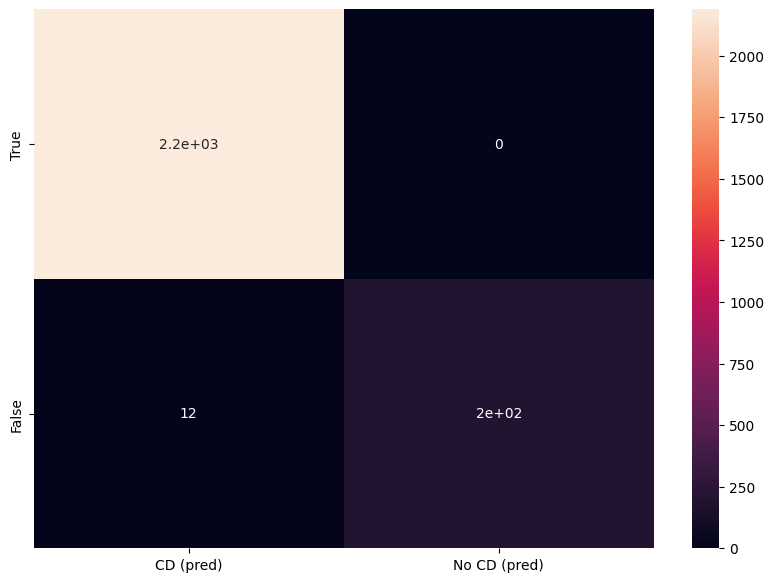

In [14]:
rf_pipe = pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), 
                 ('clf', RandomForestClassifier(warm_start=True))])
rf_pipe.fit(X_train, y_train)
rf_training_score = roc_auc_score(y_train, rf_pipe.predict_proba(X_train)[:, 1])
rf_scores = cross_validate(rf_pipe, X_train, y_train, cv=5, scoring='roc_auc')
rf_predicts = rf_pipe.predict(X_test)
print(metrics.classification_report(y_test, rf_predicts))

# the confusion matrix for the rf model
rf_cm = confusion_matrix(y_test,rf_predicts)
rf_cm_df = pd.DataFrame(
    rf_cm, 
    index = ['True','False'],
    columns = [col for col in ['CD (pred)', 'No CD (pred)']])
plt.figure(figsize = (10,7))
sns.heatmap(rf_cm_df, annot=True)
plt.show()

              precision    recall  f1-score   support

       False       0.99      1.00      0.99      2188
        True       1.00      0.85      0.92       213

    accuracy                           0.99      2401
   macro avg       0.99      0.92      0.96      2401
weighted avg       0.99      0.99      0.99      2401



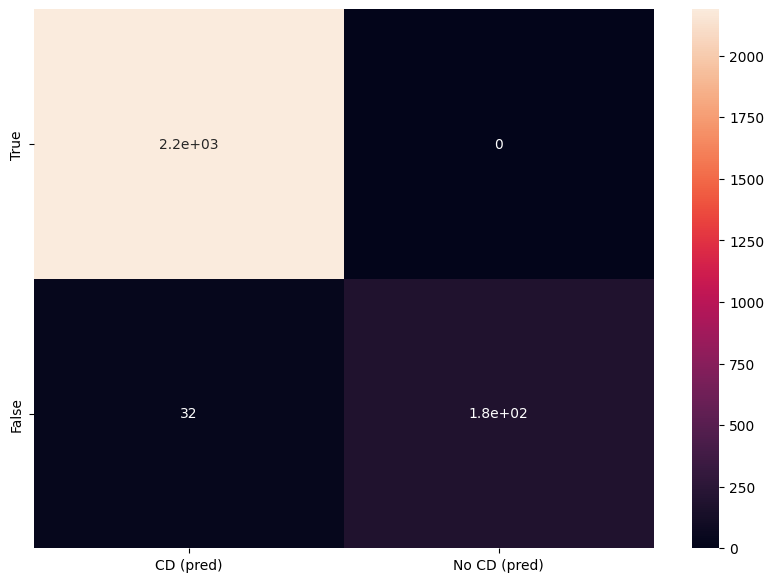

In [35]:
knn_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('enc', OneHotEncoder(handle_unknown='ignore')),
    ('clf', KNeighborsClassifier(n_neighbors=2))
])
knn_pipe.fit(X_train, y_train)
knn_training_score = roc_auc_score(y_train, knn_pipe.predict_proba(X_train)[:, 1])
knn_scores = cross_validate(knn_pipe, X_train, y_train, cv=5, scoring='roc_auc')
knn_predicts = knn_pipe.predict(X_test)
print(metrics.classification_report(y_test, knn_predicts))


# the confusion matrix for the rf model
knn_cm = confusion_matrix(y_test,knn_predicts)
knn_cm_df = pd.DataFrame(
    knn_cm, 
    index = ['True','False'],
    columns = [col for col in ['CD (pred)', 'No CD (pred)']])
plt.figure(figsize = (10,7))
sns.heatmap(knn_cm_df, annot=True)
plt.show()

              precision    recall  f1-score   support

       False       0.99      1.00      0.99      2188
        True       0.99      0.89      0.94       213

    accuracy                           0.99      2401
   macro avg       0.99      0.94      0.97      2401
weighted avg       0.99      0.99      0.99      2401



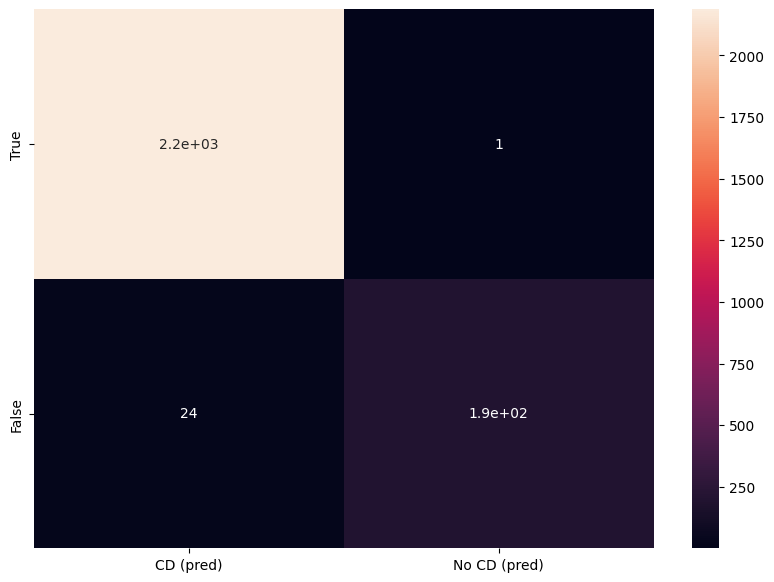

In [42]:
xgb_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('enc', OneHotEncoder(handle_unknown='ignore')),
    ('clf', xgb.XGBClassifier())
])

xgb_pipe.fit(X_train, y_train)
xgb_training_score = roc_auc_score(y_train, xgb_pipe.predict_proba(X_train)[:, 1])
xgb_scores = cross_validate(xgb_pipe, X_train, y_train, cv=5, scoring='roc_auc')
xgb_predicts = xgb_pipe.predict(X_test)
print(metrics.classification_report(y_test, xgb_predicts))

# the confusion matrix for the rf model
xgb_cm = confusion_matrix(y_test,xgb_predicts)
xgb_cm_df = pd.DataFrame(
    xgb_cm, 
    index = ['True','False'],
    columns = [col for col in ['CD (pred)', 'No CD (pred)']])
plt.figure(figsize = (10,7))
sns.heatmap(xgb_cm_df, annot=True)
plt.show()

In [17]:
nb_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('enc', OneHotEncoder(handle_unknown='ignore')),
    ('clf', MultinomialNB())
])
nb_pipe.fit(X_train, y_train)
nb_training_score = roc_auc_score(y_train, nb_pipe.predict_proba(X_train)[:, 1])
nb_scores = cross_validate(nb_pipe, X_train, y_train, cv=5, scoring='roc_auc')

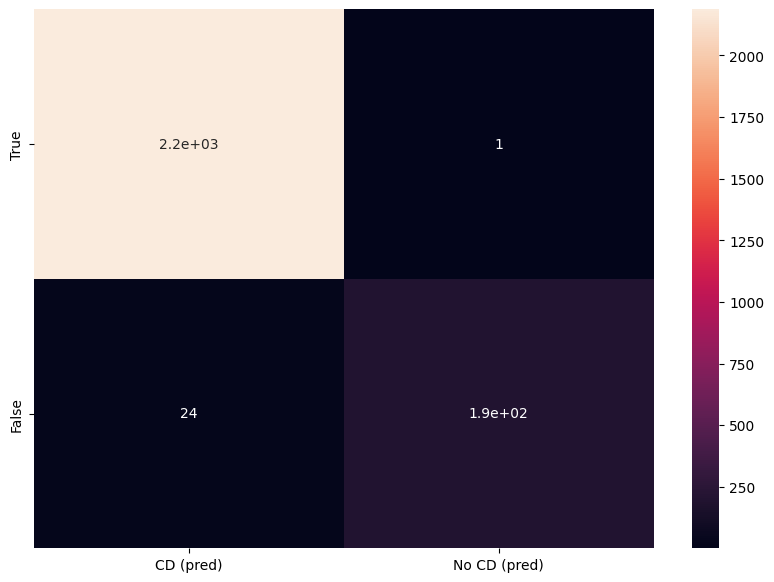

{'fit_time': array([0.01664686, 0.01534104, 0.01524496, 0.01531005, 0.01523781]),
 'score_time': array([0.00338817, 0.00334287, 0.00339723, 0.00337601, 0.00326705]),
 'test_score': array([0.79986338, 0.81011577, 0.78904566, 0.77541846, 0.80849716])}

In [18]:
dt_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('enc', OneHotEncoder(handle_unknown='ignore')),
    ('clf', DecisionTreeClassifier())
])
dt_pipe.fit(X_train, y_train)
dt_training_score = roc_auc_score(y_train, dt_pipe.predict_proba(X_train)[:, 1])
dt_scores = cross_validate(nb_pipe, X_train, y_train, cv=5, scoring='roc_auc')

# the confusion matrix for the rf model
dt_cm = confusion_matrix(y_test,xgb_predicts)
dt_cm_df = pd.DataFrame(
    dt_cm, 
    index = ['True','False'],
    columns = [col for col in ['CD (pred)', 'No CD (pred)']])
plt.figure(figsize = (10,7))
sns.heatmap(dt_cm_df, annot=True)
plt.show()
dt_scores

In [19]:
rf_training_score

1.0

In [20]:
print(rf_scores['test_score'].mean())
print(rf_scores['test_score'].std())

0.996251188467064
0.0019029612631873017


In [21]:
lr_training_score

0.8360129398370211

In [22]:
print(lr_scores['test_score'].mean())
print(lr_scores['test_score'].std())

0.8164650864914584
0.013343939066373099


In [23]:
nb_training_score

0.815951499664666

In [24]:
print(nb_scores['test_score'].mean())
print(nb_scores['test_score'].std())

0.7965880877721343
0.012966056496522329


In [25]:
knn_training_score
print(knn_scores['test_score'].mean())
print(knn_scores['test_score'].std())

0.9716804969585914
0.008695063043175768


In [37]:
if 'models' not in os.listdir('../'):
    os.mkdir('../models')

joblib.dump(xgb_pipe, '../models/gradient_boost_pipeline.sav')

['../models/gradient_boost_pipeline.sav']

In [38]:
pickle.dump(X_train, open('../data/processed/X_train.sav', 'wb'))
pickle.dump(X_test, open('../data/processed/X_test.sav', 'wb'))
pickle.dump(y_train, open('../data/processed/y_train.sav', 'wb'))
pickle.dump(y_test, open('../data/processed/y_test.sav', 'wb'))